<a href="https://colab.research.google.com/github/melirandazzo/trabajo_ciencia_datos/blob/main/Proyecto_Curso_2_Mosh_vs_Corey_Schafer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mosh vs Corey Schafer: Qué autor debería seguir si quiero aprender Python?

In [ ]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from wordcloud import WordCloud

## Preguntas de interés

* Qué autor es más popular?
* Qué tan frecuente crean contenido
* Qué autor posee contenido más reciente?
* Qué autor tiene mejor contenido?
    * Los autores fueron mejorando su contenido con el pasar del tiempo?
* Qué autor genera más contenido de Python?
    * Qué autor genera el mejor contenido en Python
    * Cuáles sonn los videos más vistos?
    * Cuál es el mejor rankeado?

## Creo funciones para conectarme y extraer datos de la API

In [ ]:
#Leo archivo con credenciales de API
#with open("credentials.json") as data:
#    cred = json.load(data)

#API_KEY = cred["key"]
API_KEY = "ingresa tu API KEY aquí (NO es seguro) o utiliza un 'secrets' file con tus credenciales (RECOMENDADO)"

In [ ]:
#creo un diccionario con los canales que deseo explorar
channel_ids=dict(corey='UCCezIgC97PvUuR4_gbFUs5g',
                 mosh='UCWv7vMbMWH4-V0ZXdmDpPBA')
print(channel_ids)

{'corey': 'UCCezIgC97PvUuR4_gbFUs5g', 'mosh': 'UCWv7vMbMWH4-V0ZXdmDpPBA'}


In [ ]:
#instancio la conexión a la API
yt = build('youtube', 'v3', developerKey=API_KEY)

In [ ]:
#creo una función para extraer información general del canal
def get_channel_info(youtube, channel_id):
    request = youtube.channels().list(
        part="snippet, contentDetails, statistics",
        id=channel_id
    )
    response = request.execute()['items'][0]

    return response

In [ ]:
#creo una función para extrar los IDs de todos los videos del canal
def get_video_list(youtube, upload_id):
    video_list = []
    request = youtube.playlistItems().list(
        part = "snippet, contentDetails",
        playlistId = upload_id,
        maxResults = 50
    )
    next_page = True
    while next_page:
        response = request.execute()
        data = response["items"]

        for video in data:
            video_id = video["contentDetails"]["videoId"]
            if video_id not in video_list:
                video_list.append(video_id)
        if "nextPageToken" in response.keys():
            request = youtube.playlistItems().list(
                part = "snippet, contentDetails",
                playlistId = upload_id,
                maxResults = 50,
                pageToken=response["nextPageToken"]
            )
        else:
            next_page=False
    return video_list

In [ ]:
#creo una función para extrar los detalles de cada uno de los videos del canal
def get_video_details(youtube, video_list):
    stats_list=[]
    for i in range(0, len(video_list),50):
        request = youtube.videos().list(
            part = "snippet, contentDetails, statistics",
            id = video_list[i:i+50]
        )
        data = request.execute()
        for video in data['items']:
            title = video["snippet"]["title"]
            published = video["snippet"]["publishedAt"]
            description = video["snippet"]["description"]
            #tag_count = len(video["snippet"]["tags"])
            view_count = video["statistics"].get("viewCount", 0)
            like_count = video["statistics"].get("likeCount", 0)
            dislike_count = video["statistics"].get("dislikeCount", 0)
            comment_count = video["statistics"].get("commentCount", 0)

            stats_dict = dict(
                title = title,
                published= published,
                description=description,
                #tag_count = tag_count,
                view_count = view_count,
                like_count = like_count,
                dislike_count = dislike_count,
                comment_count = comment_count
            )
            stats_list.append(stats_dict)
    return stats_list

In [ ]:
# creo una función de estilo "main" que ejecuta las funciones anteriores y devuelve 2 data frames
def create_channel_dataframes(yt, channel_id):
    channel_info =get_channel_info(yt, channel_id)

    playlist_id = channel_info['contentDetails']["relatedPlaylists"]["uploads"]

    video_list = get_video_list(yt, playlist_id)

    video_data = get_video_details(yt, video_list)

    misc_data =dict(
        channel_name=channel_info["snippet"]["title"],
        created_on=channel_info["snippet"]["publishedAt"],
        country=channel_info["snippet"]["country"],
        views=channel_info["statistics"]['viewCount'],
        subscribers=channel_info["statistics"]['subscriberCount'],
        number_of_videos=channel_info["statistics"]['videoCount']
    )
    return pd.DataFrame(misc_data,index=[0]), pd.DataFrame(video_data)

## Extraigo datos de Mosh y Corey

In [ ]:
print(channel_ids)

{'corey': 'UCCezIgC97PvUuR4_gbFUs5g', 'mosh': 'UCWv7vMbMWH4-V0ZXdmDpPBA'}


In [ ]:
#este bloque de código controla si ejecutamos o no la llamada a la API
if True:
    user_input = input(f"Desea descargar los datos de la API? Presione 1 para proceder, 0 para cancelar: ")

    try:
        if int(user_input)!=1:
            run = False
            #Si no descargamos datos de la API, los leemos de un repositorio.
            #Los datos de este repositorio fueron descargados el 6 de Febrero del 2022.
            misc = pd.read_csv('https://raw.githubusercontent.com/JJTorresDS/ds-data-sources/main/data_misc.csv')
            df = pd.read_csv('https://raw.githubusercontent.com/JJTorresDS/ds-data-sources/main/channel_stats.csv')
            print("La API NO fue utilizada. Los datos se descargaron de Github.")
        else:
            run = True
            print("ADVERTENCIA: Los datos serán descargados de la API (esto puede generar consumo de cuota)")
    except:
        run =False #si el usuario del notebook preta "Enter" o pone cualquier cosa sin pensar, va a defaultear a False

Desea descargar los datos de la API? Presione 1 para proceder, 0 para cancelar: 1
ADVERTENCIA: Los datos serán descargados de la API (esto puede generar consumo de cuota)


In [ ]:
if run:
    mosh_channel, mosh_video = create_channel_dataframes(yt, channel_ids['mosh'])

    corey_channel, corey_video = create_channel_dataframes(yt, channel_ids['corey'])

    #creo variables para diferenciar el origen de los datos
    mosh_channel["owner"] = "mosh"
    mosh_video["owner"] = "mosh"
    corey_channel["owner"] = "corey"
    corey_video["owner"] = "corey"

    #junto los dataframes y los salvo como '.csv'
    pd.concat([mosh_channel,corey_channel]).to_csv("data_misc.csv", index=False)
    pd.concat([mosh_video,corey_video]).to_csv("channel_stats.csv", index=False)

### Data Wrangling

In [ ]:
df["title"].isna().sum()

0

In [ ]:
df

,title,published,description,view_count,like_count,dislike_count,comment_count,owner,title_length,description_length,reactions,year,quarter,year_month,liked_per,python,view_count_millions
0,Mosh's New Year's Gift to You!,2022-01-10 10:00:10+00:00,Here's Mosh's gift to you for this new year! C...,42338,1262,0,215,mosh,30,129.0,1477,2022,2022Q1,2022-01,3.0,0,0.042338
1,Mosh's Xmas Gift (2021),2021-12-20 17:02:36+00:00,Here's Mosh's gift to you for this Christmas! ...,70634,2720,0,345,mosh,23,130.0,3065,2021,2021Q4,2021-12,4.0,0,0.070634
2,50% Off Black Friday Sale,2021-11-22 13:09:19+00:00,"Thanks to Maggie, I’m offering a 50% off Black...",87885,2666,0,351,mosh,25,144.0,3017,2021,2021Q4,2021-11,3.0,0,0.087885
3,Python Django Tutorial for Beginners,2021-06-28 08:00:31+00:00,Python Django Tutorial for Beginners - Learn D...,527430,12550,0,1267,mosh,36,1681.0,13817,2021,2021Q2,2021-06,2.0,1,0.527430
4,Docker Tutorial for Beginners [2021],2021-03-30 09:14:41+00:00,Docker Tutorial for Beginners - Learn Docker f...,716742,16848,0,801,mosh,36,1532.0,17649,2021,2021Q1,2021-03,2.0,0,0.716742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,Lab Puppy playing fetch in a lake,2014-04-25 09:34:01+00:00,My chocolate lab puppy and I playing fetch at ...,10671,354,0,19,corey,33,65.0,373,2014,2014Q2,2014-04,3.0,0,0.010671
390,Lab Puppy playing fetch in a creek,2014-04-25 09:23:56+00:00,My chocolate lab puppy and I playing fetch in ...,10129,229,0,4,corey,34,79.0,233,2014,2014Q2,2014-04,2.0,0,0.010129
391,If I'm running even 1 minute late for my dog's...,2014-04-25 08:25:06+00:00,I take my dog for a long walk every morning. A...,64067,1300,0,63,corey,62,265.0,1363,2014,2014Q2,2014-04,2.0,0,0.064067
392,Lab Puppy Diving in Snow,2014-03-21 22:32:13+00:00,Lab puppy diving into the snow for a snowball,23667,426,0,13,corey,24,45.0,439,2014,2014Q1,2014-03,2.0,0,0.023667


### Limpieza info Miscellanea
Podemos observar que la variable "created_on" figura como objeto.

Vamos a cambiarla a formate 'datetime'

In [ ]:
misc

,channel_name,created_on,country,views,subscribers,number_of_videos,owner,views_M,subscribers_K
0,Programming with Mosh,2014-10-06 18:40:53+00:00,AU,106579434,2300000,164,mosh,107,2300
1,Corey Schafer,2006-05-31 16:49:22+00:00,US,68514834,889000,230,corey,69,889


In [ ]:
misc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   channel_name      2 non-null      object             
 1   created_on        2 non-null      datetime64[ns, UTC]
 2   country           2 non-null      object             
 3   views             2 non-null      int64              
 4   subscribers       2 non-null      int64              
 5   number_of_videos  2 non-null      int64              
 6   owner             2 non-null      object             
 7   views_M           2 non-null      int64              
 8   subscribers_K     2 non-null      int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(3)
memory usage: 272.0+ bytes


In [ ]:
misc['created_on']=pd.to_datetime(misc['created_on'])
misc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   channel_name      2 non-null      object             
 1   created_on        2 non-null      datetime64[ns, UTC]
 2   country           2 non-null      object             
 3   views             2 non-null      int64              
 4   subscribers       2 non-null      int64              
 5   number_of_videos  2 non-null      int64              
 6   owner             2 non-null      object             
 7   views_M           2 non-null      int64              
 8   subscribers_K     2 non-null      int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(3)
memory usage: 272.0+ bytes


In [ ]:
misc["views_M"] = np.round(misc["views"]/1e6,0).astype(int) # millones de vistas
misc["subscribers_K"] = np.round(misc["subscribers"]/1e3,0).astype(int) # millones de usuarios
misc

,channel_name,created_on,country,views,subscribers,number_of_videos,owner,views_M,subscribers_K
0,Programming with Mosh,2014-10-06 18:40:53+00:00,AU,106579434,2300000,164,mosh,107,2300
1,Corey Schafer,2006-05-31 16:49:22+00:00,US,68514834,889000,230,corey,69,889


Sabemos que el horario que reporta Youtube está en UTC: https://stackoverflow.com/questions/62481120/what-is-the-timezone-of-publishedat-in-snippet-of-youtube-api-response

Vas a pasar el horario a la zona utilizada en Buenos Aires (GMT-3).
Sabemos que la hora en Buenos Aires está 3 horas atrasadas con respecto a UTC: https://www.worldtimebuddy.com/utc-to-argentina-buenos-aires

In [ ]:
misc["created_on"] = misc["created_on"] - timedelta(hours=3, minutes=0)

### Limpieza stats de los canales

La variable published debería pasarse a formate datetime.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   title                394 non-null    object             
 1   published            394 non-null    datetime64[ns, UTC]
 2   description          392 non-null    object             
 3   view_count           394 non-null    int64              
 4   like_count           394 non-null    int64              
 5   dislike_count        394 non-null    int64              
 6   comment_count        394 non-null    int64              
 7   owner                394 non-null    object             
 8   title_length         394 non-null    int64              
 9   description_length   392 non-null    float64            
 10  reactions            394 non-null    int64              
 11  year                 394 non-null    int64              
 12  quarter              3

In [ ]:
df.head()

,title,published,description,view_count,like_count,dislike_count,comment_count,owner,title_length,description_length,reactions,year,quarter,year_month,liked_per,python,view_count_millions
0,Mosh's New Year's Gift to You!,2022-01-10 10:00:10+00:00,Here's Mosh's gift to you for this new year! C...,42338,1262,0,215,mosh,30,129.0,1477,2022,2022Q1,2022-01,3.0,0,0.042338
1,Mosh's Xmas Gift (2021),2021-12-20 17:02:36+00:00,Here's Mosh's gift to you for this Christmas! ...,70634,2720,0,345,mosh,23,130.0,3065,2021,2021Q4,2021-12,4.0,0,0.070634
2,50% Off Black Friday Sale,2021-11-22 13:09:19+00:00,"Thanks to Maggie, I’m offering a 50% off Black...",87885,2666,0,351,mosh,25,144.0,3017,2021,2021Q4,2021-11,3.0,0,0.087885
3,Python Django Tutorial for Beginners,2021-06-28 08:00:31+00:00,Python Django Tutorial for Beginners - Learn D...,527430,12550,0,1267,mosh,36,1681.0,13817,2021,2021Q2,2021-06,2.0,1,0.527430
4,Docker Tutorial for Beginners [2021],2021-03-30 09:14:41+00:00,Docker Tutorial for Beginners - Learn Docker f...,716742,16848,0,801,mosh,36,1532.0,17649,2021,2021Q1,2021-03,2.0,0,0.716742


In [ ]:
df['published']=pd.to_datetime(df['published'])
df["published"] = df["published"] - timedelta(hours=3, minutes=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   title                394 non-null    object             
 1   published            394 non-null    datetime64[ns, UTC]
 2   description          392 non-null    object             
 3   view_count           394 non-null    int64              
 4   like_count           394 non-null    int64              
 5   dislike_count        394 non-null    int64              
 6   comment_count        394 non-null    int64              
 7   owner                394 non-null    object             
 8   title_length         394 non-null    int64              
 9   description_length   392 non-null    float64            
 10  reactions            394 non-null    int64              
 11  year                 394 non-null    int64              
 12  quarter              3

## Ingeniería de atributos

Vamos a crear más variables que nos ayuden a constestar nuestras preguntas de interés

In [ ]:
df["title_length"] = df['title'].str.len()
df["description_length"] = df['description'].str.len()
df["reactions"] = df["like_count"] + df["dislike_count"] + df["comment_count"]
df["year"] = df["published"].dt.year
#https://www.interviewqs.com/ddi-code-snippets/extract-month-year-pandas
df["quarter"] = df["published"].dt.to_period('Q')
df["year_month"] = df["published"].dt.to_period('M')
df["liked_per"]= np.round(100 * df["like_count"]/df["view_count"],0)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [ ]:
df["python"] = df['title'].str.contains('python', case=False) *1

In [ ]:
df[df.python == 1]

,title,published,description,view_count,like_count,dislike_count,comment_count,owner,title_length,description_length,reactions,year,quarter,year_month,liked_per,python,view_count_millions
3,Python Django Tutorial for Beginners,2021-06-28 05:00:31+00:00,Python Django Tutorial for Beginners - Learn D...,527430,12550,0,1267,mosh,36,1681.0,13817,2021,2021Q2,2021-06,2.0,1,0.527430
11,Python Machine Learning Tutorial (Data Science),2020-09-17 04:00:03+00:00,Python Machine Learning Tutorial - Learn how ...,993813,27259,0,1056,mosh,47,973.0,28315,2020,2020Q3,2020-09,3.0,1,0.993813
12,Python for Beginners - Learn Python in 1 Hour,2020-09-16 04:00:20+00:00,This Python tutorial for beginners show how to...,3777935,102610,0,7706,mosh,45,1525.0,110316,2020,2020Q3,2020-09,3.0,1,3.777935
32,Python Tutorial - Python for Beginners [Full C...,2019-02-18 06:00:08+00:00,Python tutorial - Python for beginners - Go fr...,24251231,730571,0,46880,mosh,52,2541.0,777451,2019,2019Q1,2019-02,3.0,1,24.251231
35,Python Practice - Interview Question - Fizz Bu...,2018-11-19 06:00:12+00:00,Fizz buzz is a popular Python interview questi...,65202,1281,0,114,mosh,55,650.0,1395,2018,2018Q4,2018-11,2.0,1,0.065202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,Python Tutorial: Namedtuple - When and why sho...,2015-07-07 08:30:00+00:00,Named Tuples in Python are High-performance co...,81937,2284,0,92,corey,70,1170.0,2376,2015,2015Q3,2015-07,3.0,1,0.081937
354,Python Tutorial: str() vs repr(),2015-06-15 08:00:00+00:00,A common question that pops up when dealing wi...,97087,2565,0,75,corey,32,1137.0,2640,2015,2015Q2,2015-06,3.0,1,0.097087
360,Python Tutorial: pip - An in-depth look at the...,2015-04-16 06:33:57+00:00,"In this video, we will take an in-depth look a...",189243,3009,0,155,corey,72,1166.0,3164,2015,2015Q2,2015-04,2.0,1,0.189243
361,Python Tutorial: virtualenv and why you should...,2015-04-13 20:37:52+00:00,"In this video, we will be looking at virtualen...",643304,10204,0,507,corey,71,1160.0,10711,2015,2015Q2,2015-04,2.0,1,0.643304


## Análisis Exploratorio

### Análisis metadata

In [ ]:
#uno todos los titulos en un solo string
text1 = " ".join(title for title in df.title)

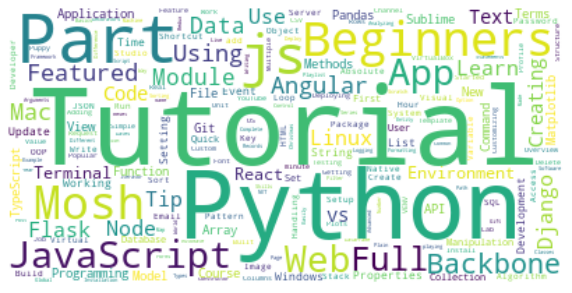

In [ ]:
# Creo una nube de palabras
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text1)

# muestro la nube de palabras
plt.figure(figsize = (10,10))
plt.imshow(word_cloud2, interpolation='bilinear')

plt.axis("off")

plt.show()

In [ ]:
#exploro los números generales de los canales
misc.sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


channel_name        Programming with MoshCorey Schafer
country                                           AUUS
views                                        175094268
subscribers                                    3189000
number_of_videos                                   394
owner                                        moshcorey
views_M                                            176
subscribers_K                                     3189
dtype: object

In [ ]:
#exploro las estadísticas de los videos
df.sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


title                  Mosh's New Year's Gift to You!Mosh's Xmas Gift...
view_count                                                     175268824
like_count                                                       4008156
dislike_count                                                          0
comment_count                                                     204637
owner                  moshmoshmoshmoshmoshmoshmoshmoshmoshmoshmoshmo...
title_length                                                       22196
description_length                                              434523.0
reactions                                                        4212793
year                                                              794765
liked_per                                                          839.0
python                                                               152
view_count_millions                                           175.268824
dtype: object

In [ ]:
#que porcentaje de videos mencionan el lenguage de programación python?
df["title"].str.contains("python", case=False).mean()

0.38578680203045684

### Valores Faltantes
Observamos que dos videos on tienen descripción.
Vamos a dejar el valor como nulo en el campo de 'description', pero vamos imputar los valores faltantes del campo "title_length" a 0.

In [ ]:
df.isna().sum()

title                  0
published              0
description            2
view_count             0
like_count             0
dislike_count          0
comment_count          0
owner                  0
title_length           0
description_length     2
reactions              0
year                   0
quarter                0
year_month             0
liked_per              0
python                 0
view_count_millions    0
dtype: int64

In [ ]:
df["title_length"]=df["title_length"].fillna(0)

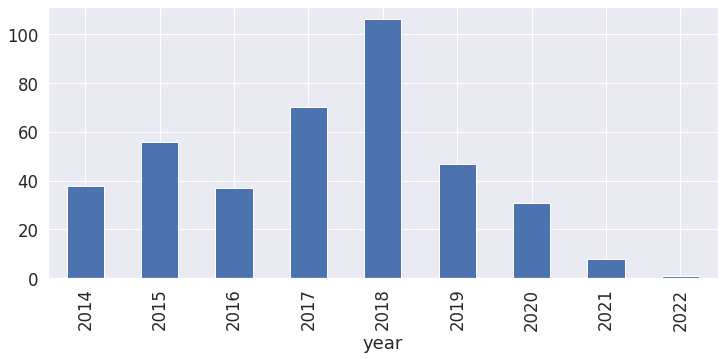

In [ ]:
plt.figure(figsize = (12,5))
df.groupby("year").size().plot(kind="bar");

### 1-Qué autor es más popular?

In [ ]:
misc[["channel_name","views", "subscribers" ]]

,channel_name,views,subscribers
0,Programming with Mosh,106579434,2300000
1,Corey Schafer,68514834,889000


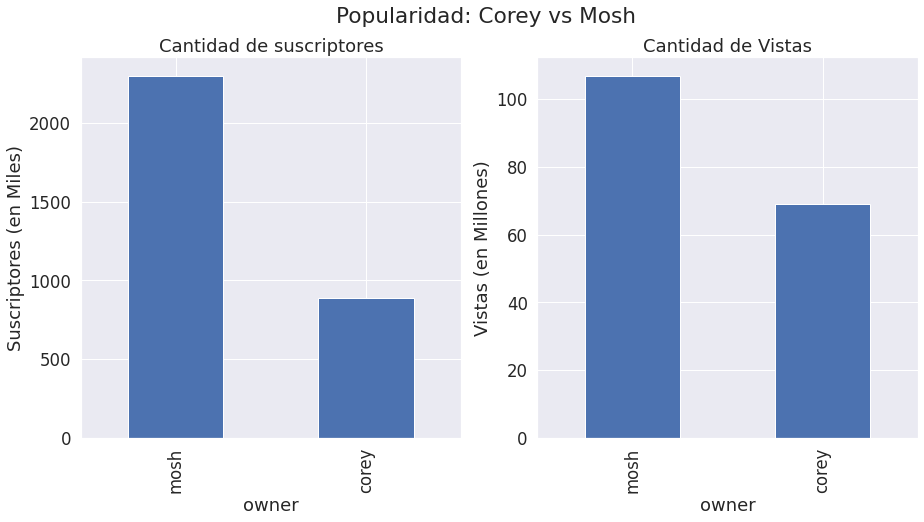

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))
fig.suptitle('Popularidad: Corey vs Mosh')
ax1.set_title("Cantidad de suscriptores")
ax1.set_ylabel("Suscriptores (en Miles)")
misc.set_index("owner")["subscribers_K"].plot(kind="bar",ax=ax1);
ax2.set_title("Cantidad de Vistas")
ax2.set_ylabel("Vistas (en Millones)")
misc.set_index("owner")["views_M"].plot(kind="bar",ax= ax2);


In [ ]:
(misc["views"]/misc["subscribers"])

0    46.338884
1    77.069555
dtype: float64

In [ ]:
misc

,channel_name,created_on,country,views,subscribers,number_of_videos,owner,views_M,subscribers_K
0,Programming with Mosh,2014-10-06 15:40:53+00:00,AU,106579434,2300000,164,mosh,107,2300
1,Corey Schafer,2006-05-31 13:49:22+00:00,US,68514834,889000,230,corey,69,889


### 2-Qué tan frecuente crean contenido

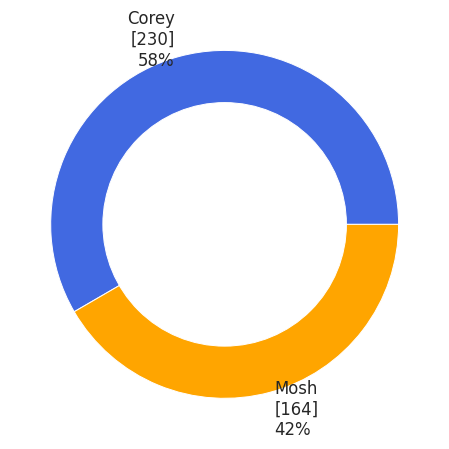

In [ ]:
totales_vid = df["owner"].value_counts().tolist()
totales_vid_per = (df["owner"].value_counts()/df.shape[0]).tolist()

# creo labels
names=["Corey\n[{}]\n{:.0f}%".format(totales_vid[0], totales_vid_per[0]*100),
       "Mosh\n[{}]\n{:.0f}%".format(totales_vid[1], totales_vid_per[1]*100)]
size_of_groups=totales_vid

fix, ax = plt.subplots(figsize = (8,8))
# creo el pieplot
plt.pie(size_of_groups, labels=names, colors=['royalblue','orange'])


# círculo blanco en el centro
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()


In [ ]:
temp=df.groupby(["quarter","owner"]).size().reset_index()

In [ ]:
temp = temp.pivot("quarter","owner",0).fillna(0)

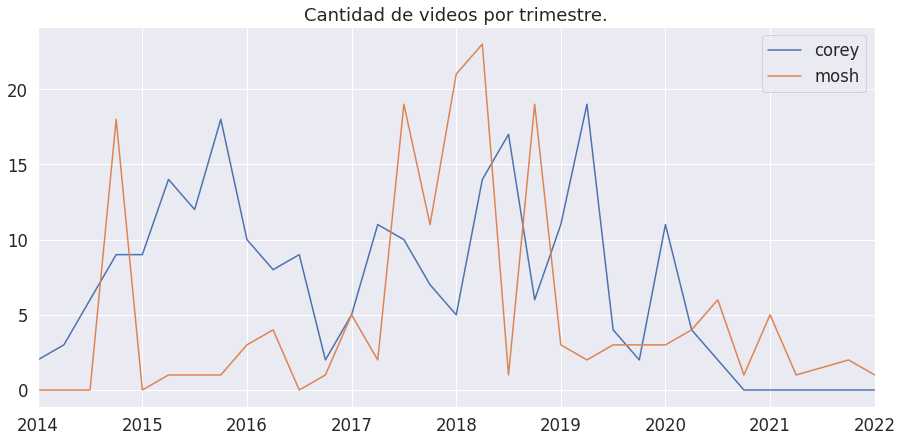

In [ ]:
plt.figure(figsize= (15,7))
plt.title("Cantidad de videos por trimestre.")
temp["corey"].plot()
temp["mosh"].plot()
plt.xlabel("")
plt.legend();

### 3-Qué autor tiene mejor contenido?

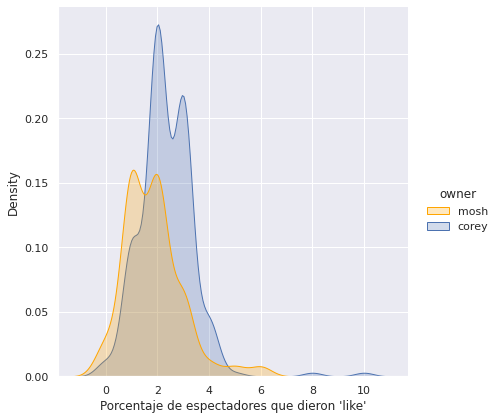

In [ ]:
sns.set(font_scale = 1)
sns.displot(df, x="liked_per", hue="owner", kind="kde", fill=True, height=6, aspect=1,palette=["orange","b"])
plt.xlabel("Porcentaje de espectadores que dieron 'like'");

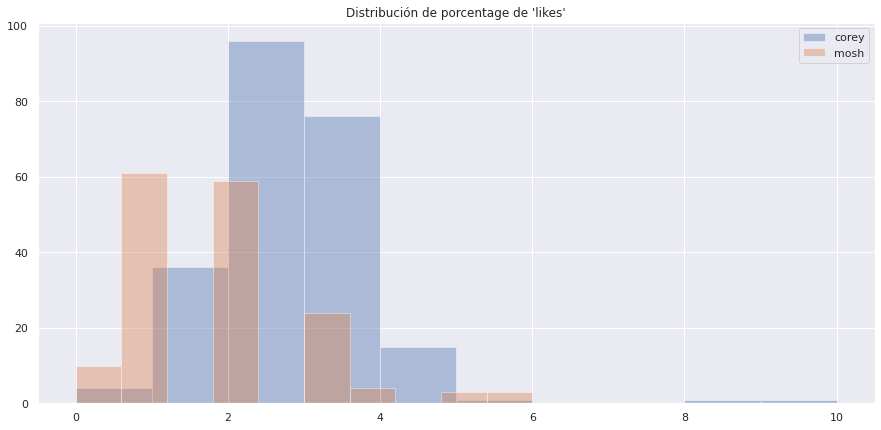

In [ ]:
plt.figure(figsize= (15,7))
plt.title("Distribución de porcentage de 'likes'")
df[df.owner=="corey"].liked_per.hist(alpha=.4, label="corey")
df[df.owner=="mosh"].liked_per.hist(alpha=.4, label="mosh")
plt.legend();

#### 3.1-Los autores fueron mejorando su contenido con el pasar del tiempo?


In [ ]:
temp=df.groupby(["quarter","owner"])["liked_per"].mean().reset_index()

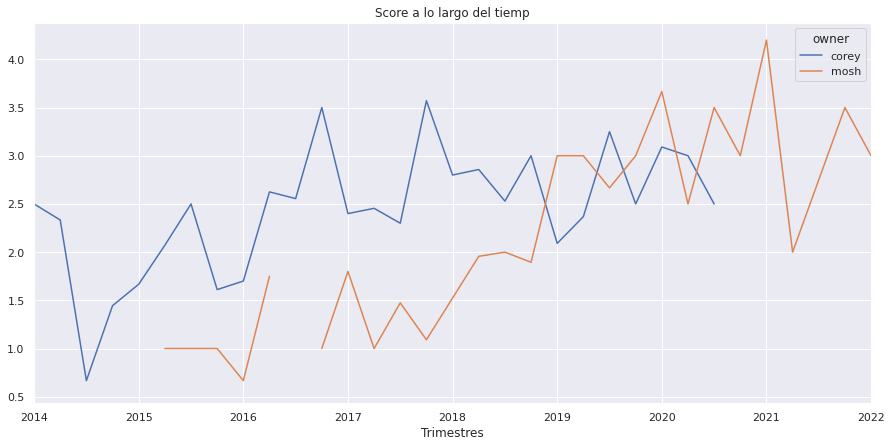

In [ ]:
temp.pivot("quarter", "owner", "liked_per").plot(title= "Score a lo largo del tiemp",
                                                           figsize=(15,7))
plt.xlabel("Trimestres");

### 4-Qué autor genera más contenido de Python?

In [ ]:
x_l=(df.groupby("owner")["python"].mean()*100).index.to_list()
y_l=(df.groupby("owner")["python"].mean()*100).round(0).to_list()

In [ ]:
y_l

[57.0, 12.0]

In [ ]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i],y_list[i],ha="center",fontsize=12)

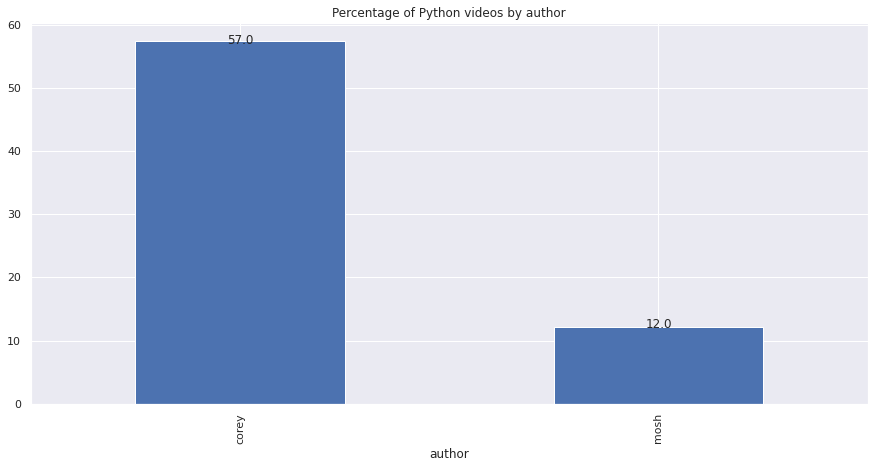

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Percentage of Python videos by author")
(df.groupby("owner")["python"].mean() *100).plot(kind="bar")
plt.xlabel("author")
add_value_label(x_l,y_l)

#### 4.1-Cuáles son los videos más vistos?

In [ ]:
df["view_count_millions"] = df["view_count"]/1e6

In [ ]:
temp = df[df.owner=="corey"].sort_values("view_count", ascending=False).head(5)

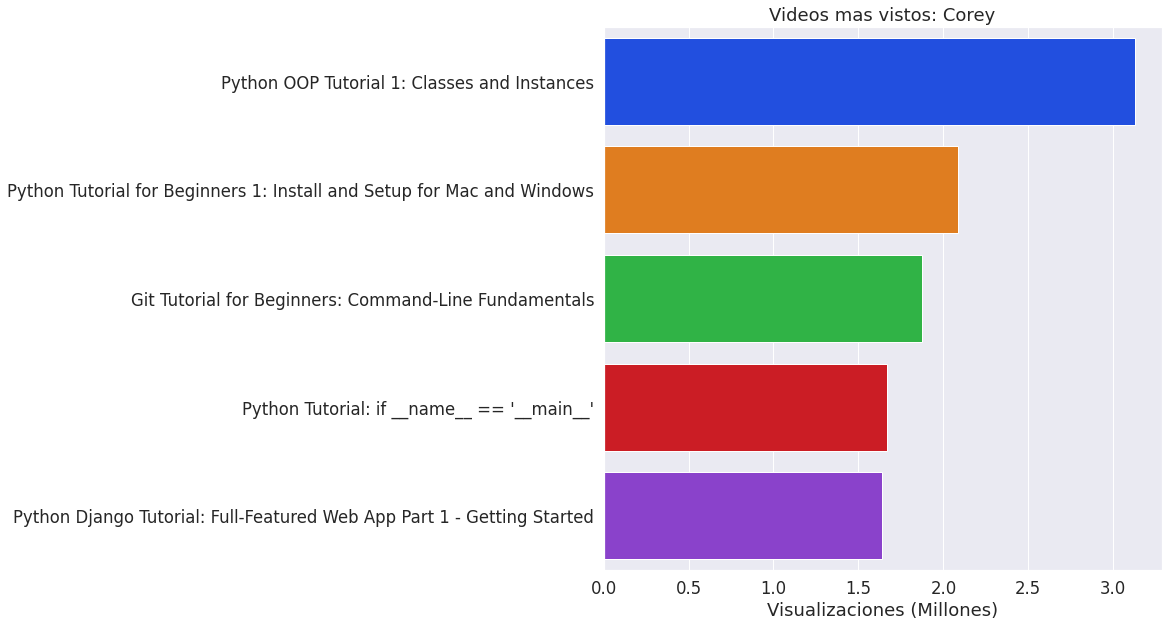

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale = 1.5)
plot = sns.barplot(x="view_count_millions", y="title", data=temp, palette="bright")
plot.set(xlabel='Visualizaciones (Millones)', ylabel='')
plot.set_title('Videos mas vistos: Corey');

In [ ]:
temp2 = df[df.owner=="mosh"].sort_values("view_count", ascending=False).head(5)

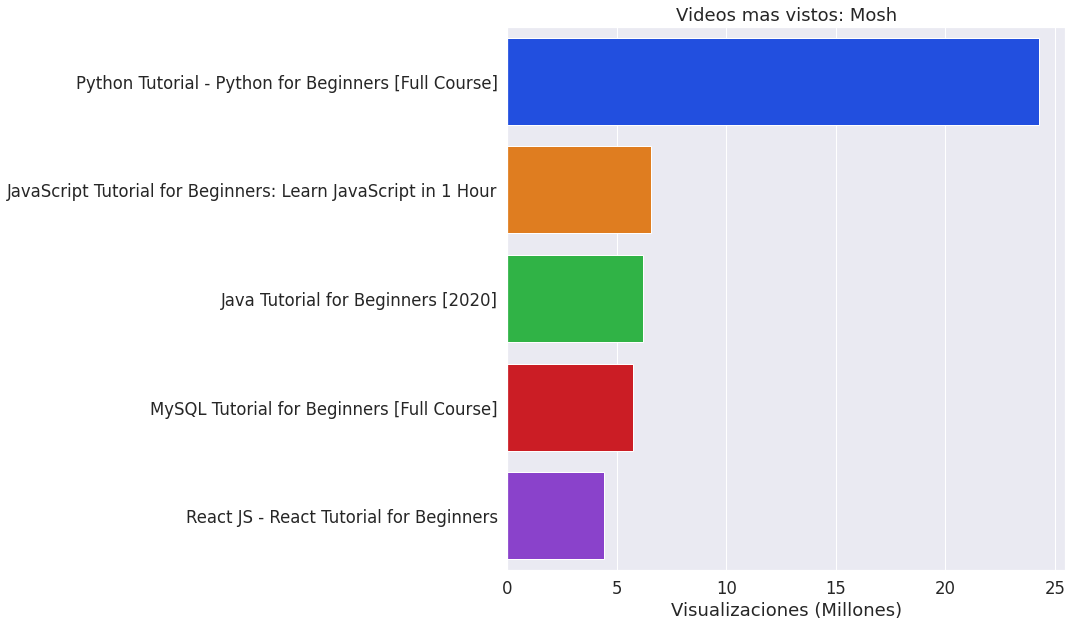

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale = 1.5)
plot = sns.barplot(x="view_count_millions", y="title", data=temp2, palette="bright")
plot.set(xlabel='Visualizaciones (Millones)', ylabel='')
plot.set_title('Videos mas vistos: Mosh');

#### 4.2-Cuáles son los videos mejor rankeados?
    

In [ ]:
temp = df[df.owner=="corey"].sort_values(["liked_per","view_count"], ascending=False)

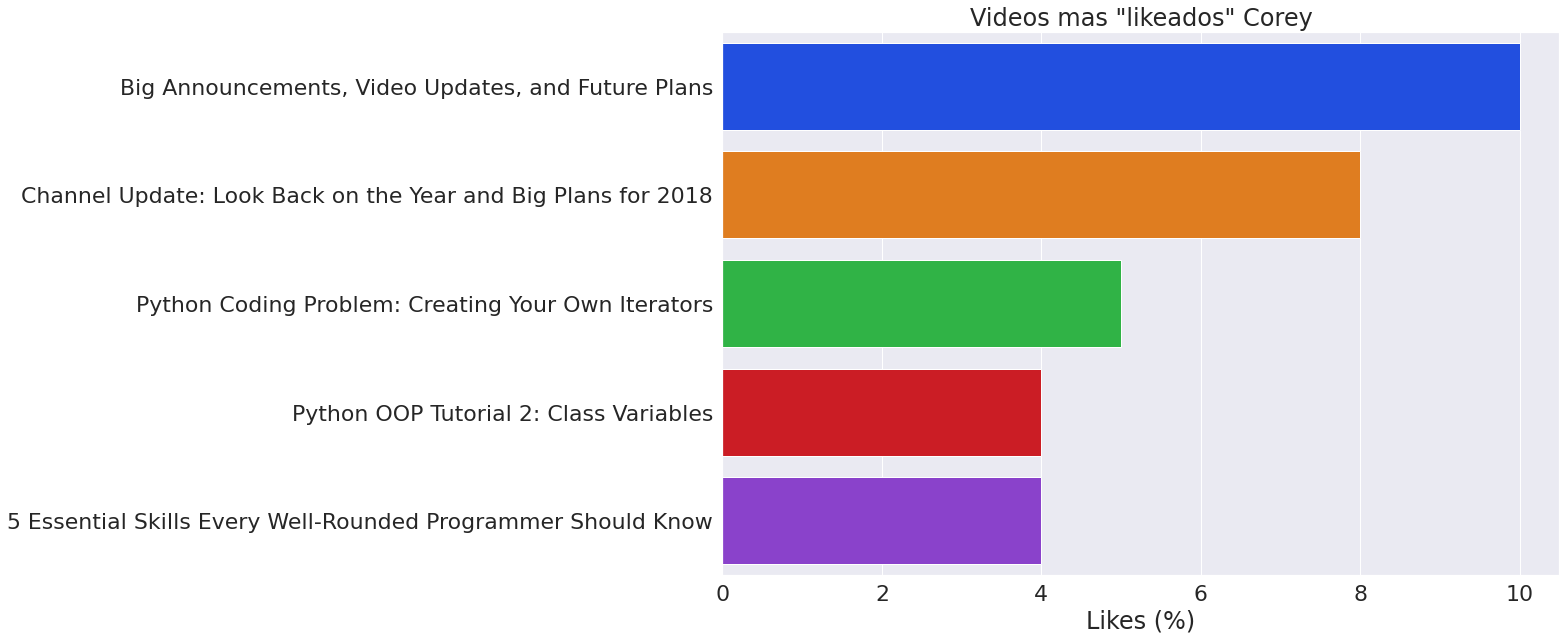

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale = 2)
plot = sns.barplot(x="liked_per", y="title", data=temp.head(5), palette="bright")
plot.set(xlabel='Likes (%)', ylabel='')
plot.set_title('Videos mas "likeados" Corey');

In [ ]:
temp2 = df[df.owner=="mosh"].sort_values(["liked_per","view_count"], ascending=False)

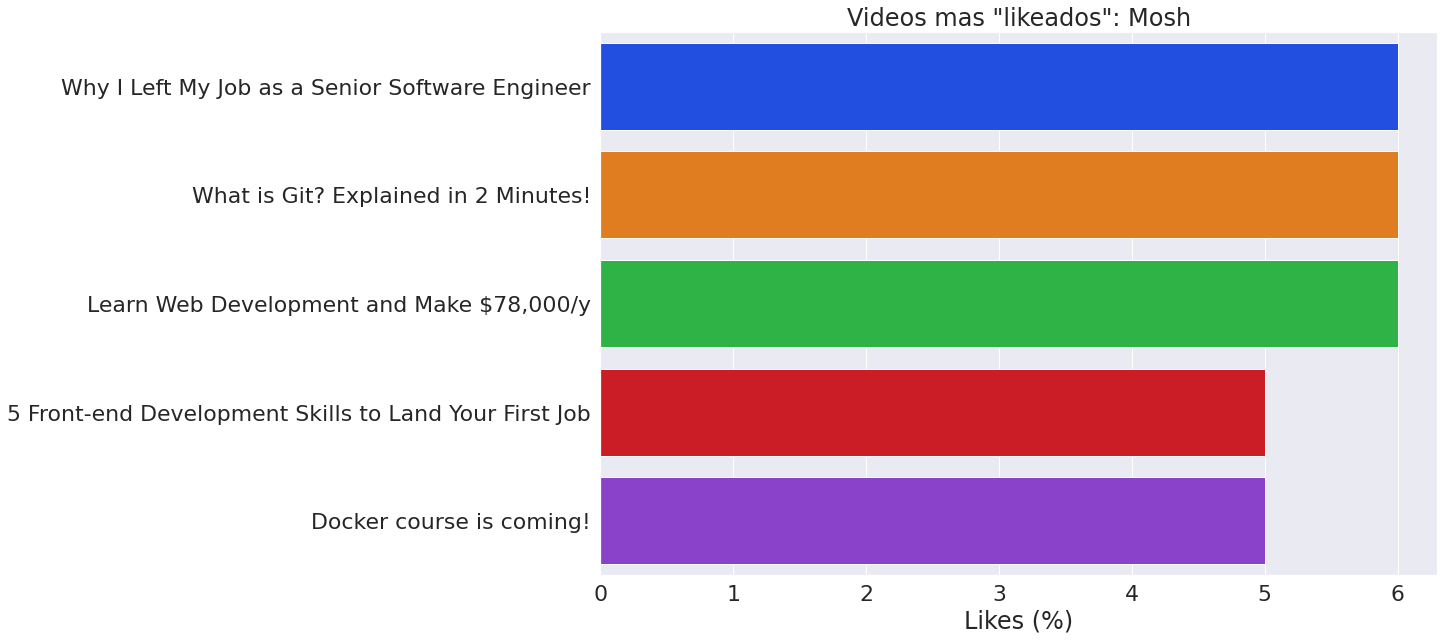

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale = 2)
plot = sns.barplot(x="liked_per", y="title", data=temp2.head(5), palette="bright")
plot.set(xlabel='Likes (%)', ylabel='')
plot.set_title('Videos mas "likeados": Mosh');

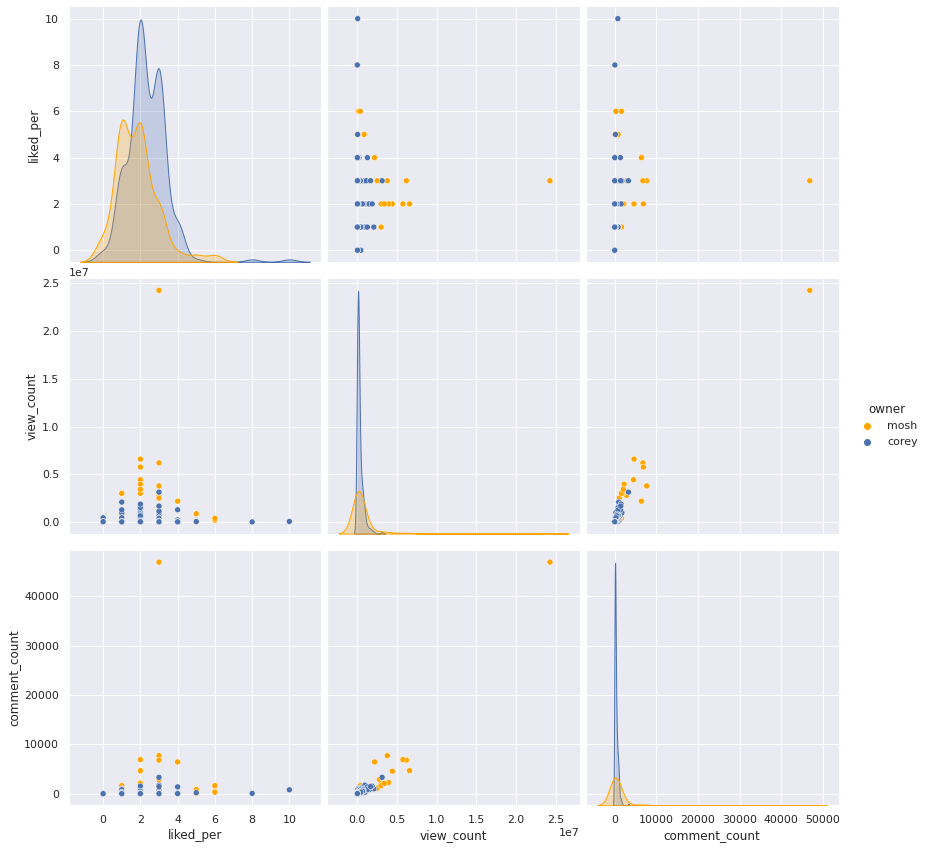

In [ ]:
sns.set(font_scale = 1)
sns.pairplot(df[["liked_per","view_count","comment_count","owner"]],hue="owner",height=4,
            palette = ["orange",'b']);

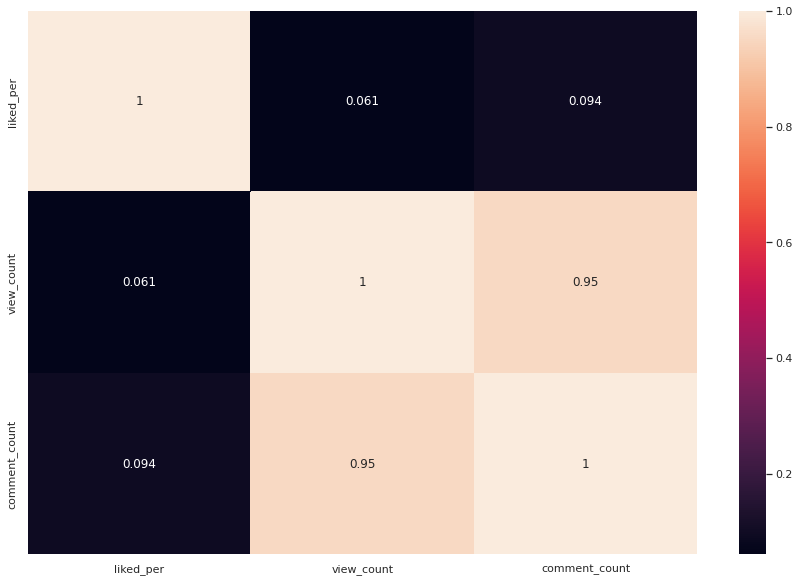

In [ ]:
sns.heatmap(df[["liked_per","view_count","comment_count"]].corr(), annot=True);

## Conclusiones finales

#### Insights Mosh
* Mosh parece enfocarse en videos introductorios.
* Abarca distintos lenguajes.
* Descubrimos que fue mejorando consistentemente la calidad de sus videos (esto puede deberse a que se dedica a vender cursos , por lo cuál esto parece ser su oficio)


**Pros**
* Sus videos introductorios son muy populares
* Abarcan diversos lenguajes

**Cons**
* Si queres estudiar temas más avanzados,  tienes que comprar uno de sus cursos

#### Insights Corey S.
* Su foco parece estar en Python (al menos 57% de sus videos)
* Logró subir el ratio de “likes” de sus videos en los primeros años y luego lo mantuvo relativamente constante (entre 2% y 3%)
* Sus videos más gustados incluyen temas avanzados de Python.
* Riesgo: hace más de un año que no sube videos (su último video fue subido finales de 2020).


**Pros**
* Sus videos más populares tratan temas avanzados
* Una de sus playlists equivale a un curso completo de python

**Cons**
* A la fecha (Diciembre 2021) Hace más de un año que no genera contenido

#### Recomendaciones

> Si estás con dudas sobre que lenguaje estudiar, Mosh parece ser una buena opción ya que parece enfocarse en lenguajes que están en demanda por el mercado.


> Si estás decidido a seguir con Python, a nivel general o con foco en Data Science,  Corey parece ser la mejor opción.
